In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from visualisation import visualize

log_file = os.path.join("logs", "mtl", "2022-03-22", "log.t-sample.csv")
visualize(log_file)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def visualise_mtl_average_loss(log_path):
    log_df = pd.read_csv(log_path)
    epochs = log_df["epoch"].unique()
    average_prom = []
    average_ss = []
    average_polya = []
    average_lr = []
    for e in epochs:
        df = log_df[log_df["epoch"] == e]
        average_prom.append(df["loss_prom"].mean())
        average_ss.append(df["loss_ss"].mean())
        average_polya.append(df["loss_polya"].mean())
        average_lr.append(df["lr"].mean())
    
    figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    axes[0][0].plot(epochs, average_prom)
    axes[0][0].set_title("average prom loss")
    axes[0][0].set_xticks(epochs)
    axes[0][1].plot(epochs, average_ss)
    axes[0][1].set_title("average ss loss")
    axes[0][1].set_xticks(epochs)
    axes[1][0].plot(epochs, average_polya)
    axes[1][0].set_title("average polya loss")
    axes[1][0].set_xticks(epochs)
    axes[1][1].plot(epochs, average_lr)
    axes[1][1].set_title("average learning rate")
    axes[1][1].set_xticks(epochs)

    plt.subplots_adjust(top=2, bottom=1, left=5, right=6, hspace=0.2, wspace=0.25)
    plt.legend()
    
visualise_mtl_average_loss(os.path.join("logs", "mtl", "2022-03-22", "log.t-sample.csv"))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_file = os.path.join("logs", "mtl", "tambora", "2022-03-18", "log1.t1300.e10.b1.g64.csv")
visualise_mtl_average_loss(log_file)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
log_file1 = os.path.join("logs", "mtl", "tambora", "2022-03-18", "log1.t1300.e10.b1.g64.1.csv")
log_file2 = os.path.join("logs", "mtl", "tambora", "2022-03-18", "log1.t1300.e10.b1.g64.2.csv")

df1 = pd.read_csv(log_file1)
df2 = pd.read_csv(log_file2)
df3 = pd.concat([df1, df2])
df3.to_csv(os.path.join("logs", "mtl", "tambora", "2022-03-18", "log1.t1300.e10.b1.g64.csv"), index=False)
    

In [ ]:
log_file = os.path.join("logs", "mtl", "tambora", "2022-03-18", "log1.t1300.e10.b1.g64.csv")
visualise_mtl_average_loss(log_file)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
def visualize_avg_loss_per_epoch(log_path):
    if not os.path.exists(log_path):
        raise FileNotFoundError("File {} not found.".format(log_path))

    df = pd.read_csv(log_path)
    epochs = list(df['epoch'].unique())
    avg_loss_prom_by_epoch = []
    avg_loss_ss_by_epoch = []
    avg_loss_polya_by_epoch = []
    for e in epochs:
        edf = df[df['epoch'] == e]
        avg_loss_prom_by_epoch.append(edf['loss_prom'].mean())
        avg_loss_ss_by_epoch.append(edf['loss_ss'].mean())
        avg_loss_polya_by_epoch.append(edf['loss_polya'].mean())

    fig, ax = plt.subplots()
    ax.plot(epochs, avg_loss_prom_by_epoch, label="avg loss prom")
    ax.plot(epochs, avg_loss_ss_by_epoch, label="avg loss ss")
    ax.plot(epochs, avg_loss_polya_by_epoch, label="avg loss polya")   
    ax.legend()

    plt.show()

log_dir = os.path.join('logs', '2022-03-05')
log_file = os.path.join(log_dir, 'log_2022-03-05-07-20-19_train.sample.csv_e5_b1_sum.csv')
visualize_avg_loss_per_epoch(log_file)


In [ ]:
"""
Create confusion matrix for MTL.
"""
from multitask_learning import init_model_mtl
from data_dir import pretrained_3kmer_dir
from utils.mtl import create_dataloader_from_csv
from transformers import BertTokenizer
import os
from tqdm import tqdm
import torch

model = init_model_mtl(pretrained_3kmer_dir)
model.eval()

tokenizer = BertTokenizer.from_pretrained(pretrained_3kmer_dir)
eval_log = os.path.join("logs", "mtl", "eval", "2022-03-17", "log.csv")
if os.path.exists(eval_log):
    os.remove(eval_log)
os.makedirs(os.path.dirname(eval_log), exist_ok=True)
log = open(eval_log, 'x')
log.write("pred_prom,label_prom,pred_ss,label_ss,pred_polya,label_polya\n")

val_csv = os.path.join("workspace", "mtl", "validation.sample.csv")
dataloader = create_dataloader_from_csv(val_csv, tokenizer, batch_size=1)
for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    input_ids, attn_mask, token_type_ids, label_prom, label_ss, label_polya = tuple(t for t in batch)
    preds = model(input_ids, attn_mask)
    pred_prom = preds["prom"]
    pred_ss = preds["ss"]
    pred_polya = preds["polya"]

    pred_prom_val, pred_prom_index = torch.max(pred_prom, dim=1)
    actual_prom = label_prom.float().item()
    predicted_prom = torch.round(pred_prom_val).item()

    pred_ss_val, pred_ss_index = torch.max(pred_ss, dim=1)
    pred_ss_index = pred_ss_index.item()
    label_ss = label_ss.item()

    pred_polya_val, pred_polya_index = torch.max(pred_polya, dim=1)
    pred_polya_index = pred_polya_index.item()
    label_polya = label_polya.item()
    
    log.write(f"{predicted_prom},{actual_prom},{pred_ss_index},{label_ss},{pred_polya_index},{label_polya}\n")

    #print(pred_prom, pred_prom_index, label_prom)
    #print(pred_ss, pred_ss_index, label_ss)
    #print(pred_polya, pred_polya_index, label_polya)

log.close()

In [ ]:
from multitask_learning import evaluate, init_model_mtl
from data_dir import pretrained_3kmer_dir
import torch
import os
from utils.mtl import create_dataloader_from_csv
from transformers import BertTokenizer

summary = {}
tokenizer = BertTokenizer.from_pretrained(pretrained_3kmer_dir)
dataloader = create_dataloader_from_csv(os.path.join("workspace", "mtl", "validation.sample.csv"), tokenizer)
for model_epoch in range(10):
    model = init_model_mtl(pretrained_3kmer_dir)
    model.load_state_dict(torch.load(os.path.join("result", "mtl", "2022-03-17", f"epoch-{model_epoch}.pth")), strict=False)
    model.eval()
    pred_acc, ss_acc, polya_acc = evaluate(model, dataloader, os.path.join("logs", "mtl", "2022-03-17", f"validation.epoch.{model_epoch}.csv"))
    t = (pred_acc, ss_acc, polya_acc)
    summary[f"epoch-{model_epoch}"] = t
summary

In [ ]:
t = (1, 2, 3)
t

In [ ]:
"""
Create confusion matrix.
"""
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
eval_log = os.path.join("logs", "mtl", "eval", "2022-03-17", "log.csv")
df = pd.read_csv(eval_log)
pred_prom = list(df['pred_prom'])
label_prom = list(df['label_prom'])
cf_matrix_prom = confusion_matrix(pred_prom, label_prom)
print(cf_matrix_prom)
pred_ss = list(df['pred_ss'])
label_ss = list(df['label_ss'])
cf_matrix_ss = confusion_matrix(pred_ss, label_ss)
print(cf_matrix_ss)
pred_polya = list(df['pred_polya'])
label_polya = list(df['label_polya'])
cf_matrix_polya = confusion_matrix(pred_polya, label_polya)
print(cf_matrix_polya)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix_prom, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Promoter Prediction\n\n')
ax.set_xlabel('Predicted Promoter \n')
ax.set_ylabel('Actual Promoter ')

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix_ss, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Splice Sites (SS) Prediction\n\n')
ax.set_xlabel('Predicted SS \n')
ax.set_ylabel('Actual SS ')

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix_polya, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix PolyA Prediction\n\n')
ax.set_xlabel('Predicted PolyA \n')
ax.set_ylabel('Actual PolyA ')

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
seqlab_10_prediction, seqlab_10_target = create_confusion_matrix()

In [ ]:


preds, targets = create_confusion_matrix(os.path.join("run", "seqlab-tiny-base-b64-e50-20220704-215933", "eval_log.csv"))
print(preds.shape)
print(targets.shape)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))

ax = sns.heatmap(
    confusion_matrix(preds, targets)
    , annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Token Prediction\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 26773/26773 [12:05<00:00, 36.93it/s]


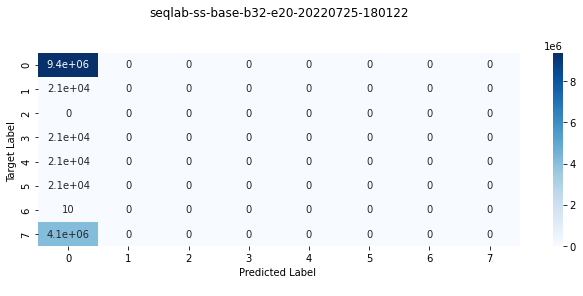

In [2]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds, targets = create_confusion_matrix(os.path.join("run", "seqlab-ss-base-b32-e20-20220725-180122", "eval_log.csv"))
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('seqlab-ss-base-b32-e20-20220725-180122\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 26773/26773 [11:38<00:00, 38.31it/s]


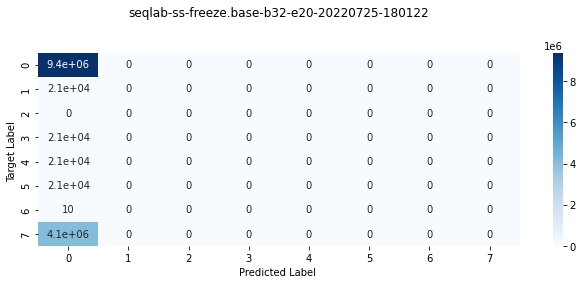

In [3]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds, targets = create_confusion_matrix(os.path.join("run", "seqlab-ss-freeze.base-b32-e20-20220725-180122", "eval_log.csv"))
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('seqlab-ss-freeze.base-b32-e20-20220725-180122\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 28622/28622 [12:25<00:00, 38.39it/s]


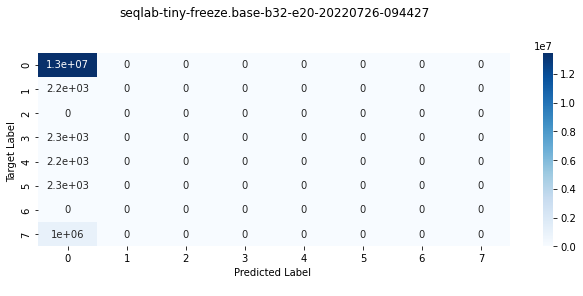

In [4]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds, targets = create_confusion_matrix(os.path.join("run", "seqlab-tiny-freeze.base-b32-e20-20220726-094427", "eval_log.csv"))
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('seqlab-tiny-freeze.base-b32-e20-20220726-094427\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 28622/28622 [12:24<00:00, 38.45it/s]


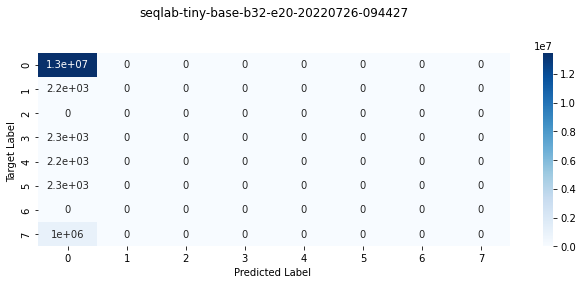

In [5]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds, targets = create_confusion_matrix(os.path.join("run", "seqlab-tiny-base-b32-e20-20220726-094427", "eval_log.csv"))
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('seqlab-tiny-base-b32-e20-20220726-094427\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 34496/34496 [16:15<00:00, 35.36it/s]


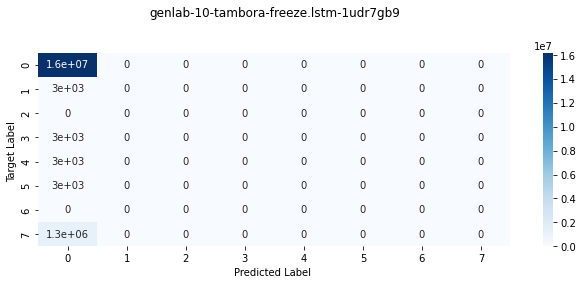

In [6]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds, targets = create_confusion_matrix(os.path.join("run", "genlab-10-tambora-freeze.lstm-1udr7gb9", "validation_log.csv"))
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('genlab-10-tambora-freeze.lstm-1udr7gb9\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 34496/34496 [19:38<00:00, 29.27it/s]


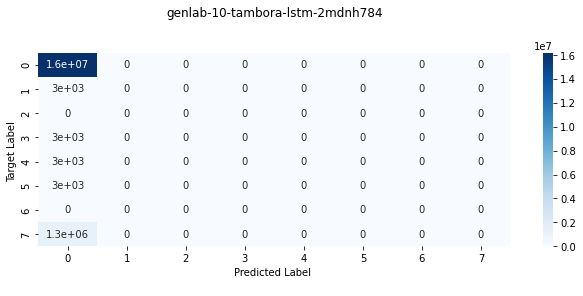

In [2]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds, targets = create_confusion_matrix(os.path.join("run", "genlab-10-tambora-lstm-2mdnh784", "validation_log.csv"))
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('genlab-10-tambora-lstm-2mdnh784\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 28622/28622 [18:38<00:00, 25.59it/s]


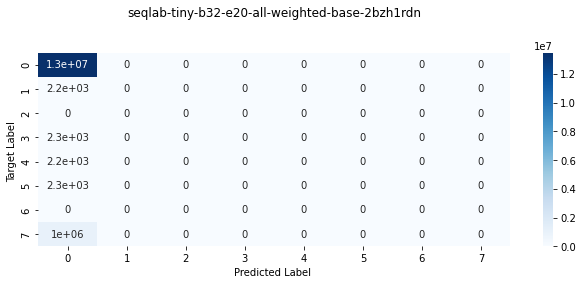

In [7]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_log_path = os.path.join("run", "seqlab-tiny-b32-e20-all-weighted-base-2bzh1rdn", "eval_log.csv")
preds, targets = create_confusion_matrix(validation_log_path, 8)
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('seqlab-tiny-b32-e20-all-weighted-base-2bzh1rdn\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 28622/28622 [14:06<00:00, 33.81it/s]


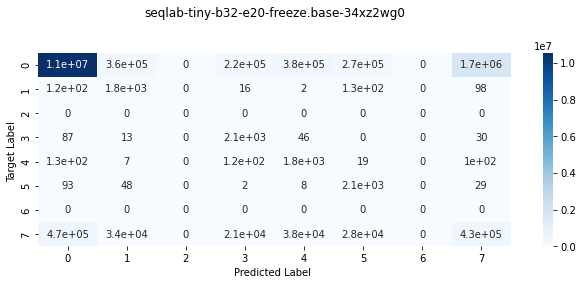

In [4]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_log_path = os.path.join("run", "seqlab-tiny-b32-e20-freeze.base-34xz2wg0", "eval_log.csv")
preds, targets = create_confusion_matrix(validation_log_path, 8)
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('seqlab-tiny-b32-e20-freeze.base-34xz2wg0\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 26773/26773 [14:29<00:00, 30.80it/s]


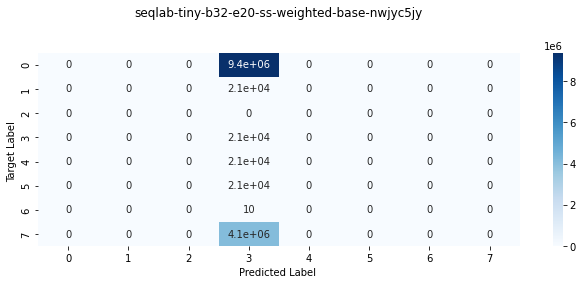

In [5]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_log_path = os.path.join("run", "seqlab-tiny-b32-e20-ss-weighted-base-nwjyc5jy", "eval_log.csv")
preds, targets = create_confusion_matrix(validation_log_path, 8)
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('seqlab-tiny-b32-e20-ss-weighted-base-nwjyc5jy\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 26773/26773 [13:11<00:00, 33.81it/s]


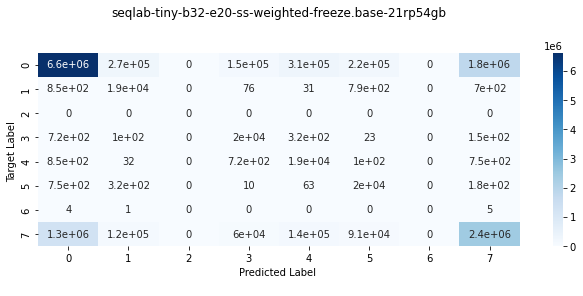

In [6]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_log_path = os.path.join("run", "seqlab-tiny-b32-e20-ss-weighted-freeze.base-21rp54gb", "eval_log.csv")
preds, targets = create_confusion_matrix(validation_log_path, 8)
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('seqlab-tiny-b32-e20-ss-weighted-freeze.base-21rp54gb\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : : 0it [00:00, ?it/s]


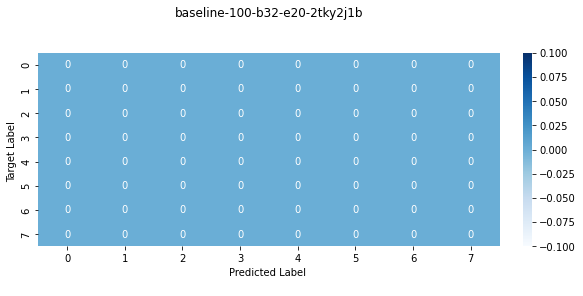

In [3]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_log_path = os.path.join("run", "baseline-100-b32-e20-2tky2j1b", "validation_log.19.csv")
preds, targets = create_confusion_matrix(validation_log_path, 0.1)
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('baseline-100-b32-e20-2tky2j1b\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 17539/17539 [04:09<00:00, 70.16it/s]


Text(-0.9997599999999984, 0.5, 'Target Label ')

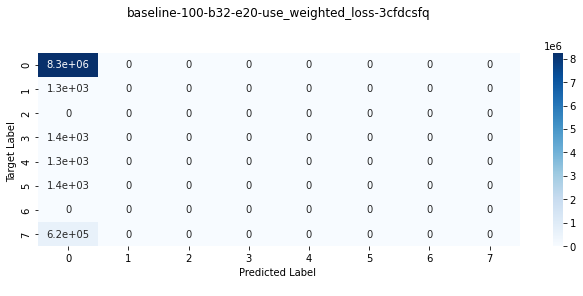

In [2]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_log_path = os.path.join("run", "baseline-100-b32-e20-use_weighted_loss-3cfdcsfq", "validation_log.19.csv")
preds, targets = create_confusion_matrix(validation_log_path, frac=0.1)
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('baseline-100-b32-e20-use_weighted_loss-3cfdcsfq\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.


Processing : 100%|██████████| 17539/17539 [04:45<00:00, 61.37it/s]


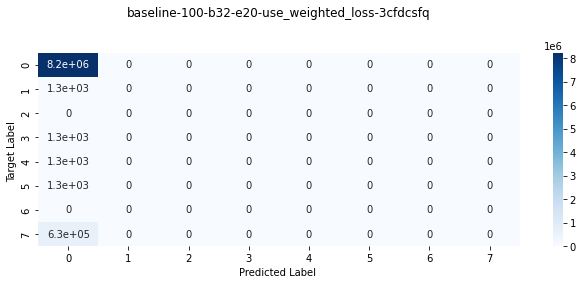

In [4]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_log_path = os.path.join("run", "baseline-100-b32-e20-use_weighted_loss-3cfdcsfq", "validation_log.19.csv")
preds, targets = create_confusion_matrix(validation_log_path, frac=0.1)
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('baseline-100-b32-e20-use_weighted_loss-3cfdcsfq\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing : 100%|██████████| 18/18 [00:00<00:00, 2251.04it/s]


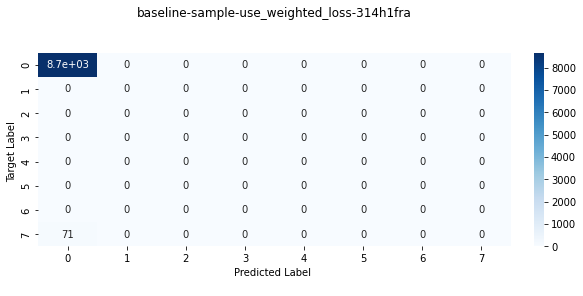

In [7]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_log_path = os.path.join("run", "baseline-sample-use_weighted_loss-314h1fra", "validation_log.csv")
preds, targets = create_confusion_matrix(validation_log_path)
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('baseline-sample-use_weighted_loss-314h1fra\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()


Processing : 100%|██████████| 18/18 [00:00<00:00, 1999.88it/s]


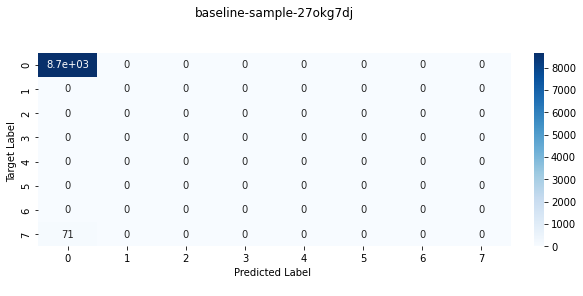

In [8]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_log_path = os.path.join("run", "baseline-sample-27okg7dj", "validation_log.csv")
preds, targets = create_confusion_matrix(validation_log_path)
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('baseline-sample-27okg7dj\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

In [9]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_log_path = os.path.join("run", "sequence-labelling-25-b32-e10-use_weighted_loss-freeze.base-3mmoa8x5", "eval_log.9.csv")
preds, targets = create_confusion_matrix(validation_log_path)
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('sequence-labelling-25-b32-e10-use_weighted_loss-freeze.base-3mmoa8x5\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()

Processing :  30%|██▉       | 12965/43848 [03:59<28:55, 17.79it/s]

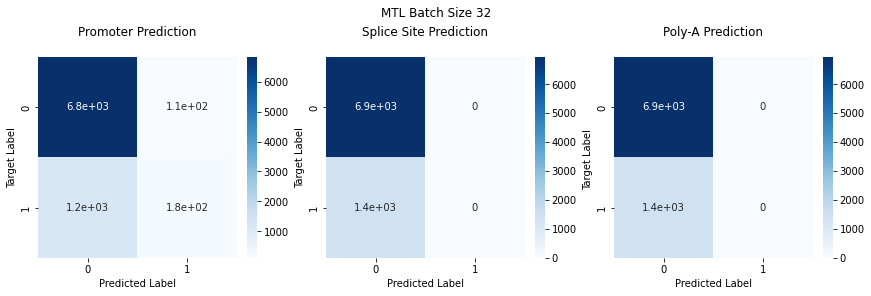

In [22]:
from utils.confusion_matrix import create_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

validation_log_path = os.path.join("run", "sequence-labelling-25-b32-e10_use_weighted_loss-base-2l266q15", "eval_log.9.csv")
preds, targets = create_confusion_matrix(validation_log_path)
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax = sns.heatmap(confusion_matrix(targets, preds, labels=[0,1,2,3,4,5,6,7]), annot=True, cmap='Blues')
ax.set_title('sequence-labelling-25-b32-e10_use_weighted_loss-base-2l266q15\n\n')
ax.set_xlabel('Predicted Label \n')
ax.set_ylabel('Target Label ')

## Display the visualization of the Confusion Matrix.

plt.show()


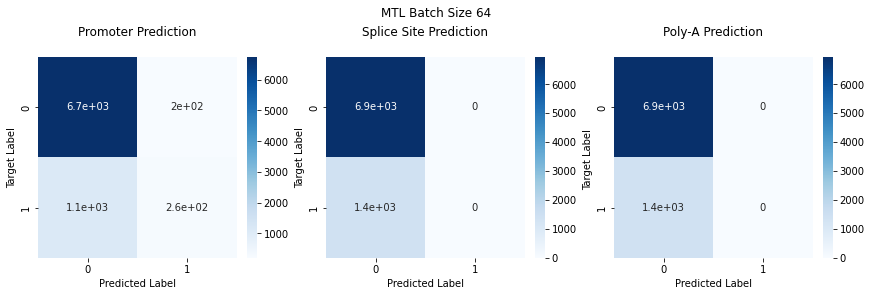

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(12,4))
fig.suptitle("MTL Batch Size 64")
ax, ax2, ax3 = axes

sns.heatmap(mtl_b64_cf_matrix[0], annot=True, cmap='Blues', ax=ax)
ax.set_title('Promoter Prediction\n')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Target Label')

sns.heatmap(mtl_b64_cf_matrix[1], annot=True, cmap='Blues', ax=ax2)
ax2.set_title('Splice Site Prediction\n')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('Target Label')

sns.heatmap(mtl_b64_cf_matrix[2], annot=True, cmap='Blues', ax=ax3)
ax3.set_title('Poly-A Prediction\n')
ax3.set_xlabel('Predicted Label')
ax3.set_ylabel('Target Label ')

plt.show()

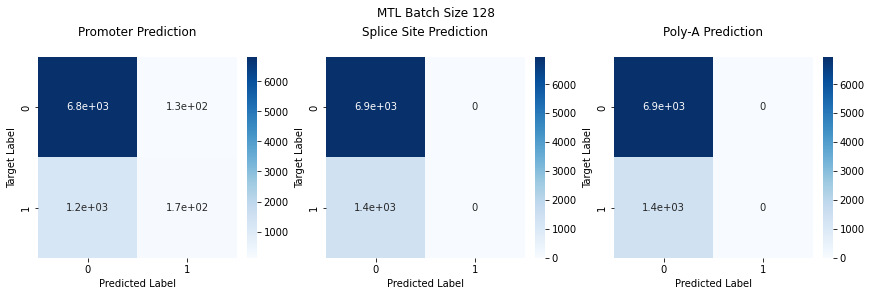

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(12,4))
fig.suptitle("MTL Batch Size 128")
ax , ax2, ax3 = axes

sns.heatmap(mtl_b128_cf_matrix[0], annot=True, cmap='Blues', ax=ax)
ax.set_title('Promoter Prediction\n')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Target Label')

sns.heatmap(mtl_b128_cf_matrix[1], annot=True, cmap='Blues', ax=ax2)
ax2.set_title('Splice Site Prediction\n')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('Target Label')

sns.heatmap(mtl_b128_cf_matrix[2], annot=True, cmap='Blues', ax=ax3)
ax3.set_title('Poly-A Prediction\n')
ax3.set_xlabel('Predicted Label')
ax3.set_ylabel('Target Label')

plt.show()

In [ ]:
import pandas as pd
import os 

path = os.path.join("run", "genlab-10-tambora-lstm-2mdnh784", "validation_log.csv")
def count_label(csv):
    pred, target = {}, {}
    for i in range(8):
        pred[str(i)] = 0
        target[str(i)] = 0
    
    pred["-100"] = 0
    target["-100"] = 0
    
    df = pd.read_csv(csv)
    for i, r in df.iterrows():
        target_label = r["target"].split(' ')
        prediction = r["prediction"].split(' ')
        for j in range(512):
            pred[prediction[j]] += 1
            target[target_label[j]] += 1
    return pred, target

pred, target = count_label(path)
pred, target
        

In [ ]:
from utils.seqlab import Index_Dictionary
pred_tokens = {}
target_tokens = {}
for k in pred.keys():
    pred_tokens[Index_Dictionary[int(k)]] = pred[k]
    target_tokens[Index_Dictionary[int(k)]] = target[k]

pred_tokens, target_tokens


In [ ]:
print(pred_tokens, target_tokens)
s = 0
for k in target_tokens.keys():
    s += target_tokens[k]
print(s)

In [ ]:
dfs = filter_df_by_epoch(os.path.join("run", "seqlab-tiny-base-b64-e50-20220704-215933", "eval_log.csv"),
    [0, 9, 19, 29, 39, 49]
    )

preds0, targets0 = create_cf_matrix(dfs[0]) # After one epoch.
preds9, targets9 = create_cf_matrix(dfs[1]) # After 10 epochs.
preds19, targets19 = create_cf_matrix(dfs[2]) # After 20 epochs.
preds29, targets29 = create_cf_matrix(dfs[3]) # After 30 epochs.
preds39, targets39 = create_cf_matrix(dfs[4]) # After 40 epochs.
preds49, targets49 = create_cf_matrix(dfs[5]) # After 50 epochs.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

figs, axes = plt.subplots(nrows=6, ncols=1, constrained_layout=True)

axes[0] = sns.heatmap(
    confusion_matrix(preds0, targets0)
    , annot=True, cmap='Blues')

axes[0].set_title('Confusion Matrix Token Prediction After First Epoch\n\n')
axes[0].set_xlabel('Predicted Label \n')
axes[0].set_ylabel('Target Label ')

axes[1] = sns.heatmap(
    confusion_matrix(preds9, targets9)
    , annot=True, cmap='Blues')

axes[1].set_title('Confusion Matrix Token Prediction After Epoch 10\n\n')
axes[1].set_xlabel('Predicted Label \n')
axes[1].set_ylabel('Target Label ')

axes[2] = sns.heatmap(
    confusion_matrix(preds19, targets19)
    , annot=True, cmap='Blues')

axes[2].set_title('Confusion Matrix Token Prediction After Epoch 20\n\n')
axes[2].set_xlabel('Predicted Label \n')
axes[2].set_ylabel('Target Label ')

axes[3] = sns.heatmap(
    confusion_matrix(preds29, targets29)
    , annot=True, cmap='Blues')

axes[3].set_title('Confusion Matrix Token Prediction After Epoch 30\n\n')
axes[3].set_xlabel('Predicted Label \n')
axes[3].set_ylabel('Target Label ')

axes[4] = sns.heatmap(
    confusion_matrix(preds39, targets39)
    , annot=True, cmap='Blues')

axes[4].set_title('Confusion Matrix Token Prediction After Epoch 40\n\n')
axes[4].set_xlabel('Predicted Label \n')
axes[4].set_ylabel('Target Label ')


axes[5] = sns.heatmap(
    confusion_matrix(preds49, targets49)
    , annot=True, cmap='Blues')

axes[5].set_title('Confusion Matrix Token Prediction After Epoch 50\n\n')
axes[5].set_xlabel('Predicted Label \n')
axes[5].set_ylabel('Target Label ')

plt.show()




In [ ]:
import numpy as np
a = [
    [[1], [2], [3]],
    [[4], [5], [6]]
]
x = np.asarray(a)
print(x.shape)
x = np.squeeze(x, axis=2)
print(x.shape)
print(x)
z = np.squeeze(x[0])
z


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def visualize_log_seq2seq(log_path):
    log_df = pd.read_csv(log_path)
    epoch = list(log_df['epoch'].unique())
    epochs = [i for i in range(len(epoch))]
    subplot_id = 320
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)

    for e in epochs:
        e_df = log_df[log_df['epoch'] == e]
        len_e = len(e_df)
        loss = list(e_df['loss'])
        steps = [(k+1) for k in range(0, len_e)]
        subplot_id += 1
        ax = fig.add_subplot(subplot_id)
        ax.plot(steps, loss, label='loss ')
        ax.set_title('epoch {}'.format(e+1))
        ax.set_xlabel('steps')
        ax.set_ylabel('loss')
        ax.legend()
        
    plt.subplots_adjust(top=1.5, bottom=1, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

def visualize_average_epoch_loss(log_path):
    log_df = pd.read_csv(log_path)
    epochs = log_df["epoch"].unique()
    averages = []
    for e in epochs:
        loss_by_epoch_df = log_df[log_df["epoch"] == e]
        average = loss_by_epoch_df["loss"].mean()
        averages.append(average)

    fig = plt.figure()
    subplot_id = 110
    ax = fig.add_subplot(subplot_id + 1)
    ax.plot(epochs, averages)
    ax.set_title("average loss per epoch")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.legend()
    plt.xticks(np.arange(0, len(epochs), step=1))
    plt.subplots_adjust(top=1.5, bottom=1, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()


In [ ]:
import os
seq2seq_log = os.path.join("logs", "seq2seq", "bundle.sample", "log_e5_b1_g1.csv")
visualize_log_seq2seq(seq2seq_log)

In [ ]:
import os
seq2seq_log = os.path.join("logs", "seq2seq", "bundle.sample", "log_e5_b1_g1.csv")
visualize_average_epoch_loss(seq2seq_log)

In [ ]:
# Bert Visualization

from bertviz import head_view, model_view
import os
from models.seqlab import DNABERT_SL
from transformers import BertForMaskedLM, BertTokenizer
from utils.seqlab import preprocessing_kmer, _process_label, _process_sequence
import pandas as pd
import torch

bert_path = os.path.join("pretrained", "3-new-12w-0")
tokenizer = BertTokenizer.from_pretrained(bert_path)
bert = BertForMaskedLM.from_pretrained(bert_path).bert
model = DNABERT_SL(bert, None)
test_data = os.path.join("workspace", "seqlab", "seqlab.strand-positive.kmer.stride-510.from-index", "sample.csv")
test_dataloader = preprocessing_kmer(test_data, tokenizer, batch_size=1)

In [ ]:
test_data_df = pd.read_csv(test_data)
sequence = test_data_df.iloc[0]["sequence"]
label = test_data_df.iloc[0]["label"]
input_ids, attention_mask, token_type_ids = _process_sequence(sequence, tokenizer)
arr_input_ids = []
arr_input_ids.append(input_ids)
arr_input_ids = torch.tensor(arr_input_ids)
arr_attention_mask = []
arr_attention_mask.append(attention_mask)
arr_attention_mask = torch.tensor(arr_attention_mask)
label_ids = _process_label(label)
pred, bert_output = model(arr_input_ids, arr_attention_mask)



In [ ]:
attention = bert_output[-1]
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)
print(attention)

In [ ]:
head_view(attention, tokens, -1)

In [ ]:
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

model_version = os.path.join('pretrained', 'bert-base-uncased')
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "The cat sat on the mat"
sentence_b = "The cat lay on the rug"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 


In [ ]:
sentence_b_start
attention
tokens

In [ ]:
head_view(attention, tokens, sentence_b_start)


In [ ]:
import utils.seqlab

utils.seqlab.NUM_LABELS